# ML pipeline



- In this notebook, we will provide some explanations on the developed ML pipeline. We use kubeflow for orchestration where we build components based on Python functions. Note that we first tried to orchestrate the pipeline using tfx pipelines but it took us a lot of development time, especially to orchestrate other ML frameworks than tf. This is why we switched to kubeflow, but TFX is still more suitable for ML pipelines and for productions requiring low latency. Thanks to the use of the tensorflow graph, tfx can significantly reduce the execution time. 


- The complete script to generate the kubeflow pipeline is available at [decathlon_pipeline.py](../deployment_pipeline/decathlon_pipeline.py). 

- The image below shows the pipeline components after running on the kubernetes cluster. This is a simple demo pipeline, in production. Other components must be added such as:
    - Data validation component
    - Hyperparameters auto-tuning in training component
    - Model validation component
    - Batch prediction triggers in prediction component
    - Model Monitoring component with Data drift monitoring or/and Model skew monitoring

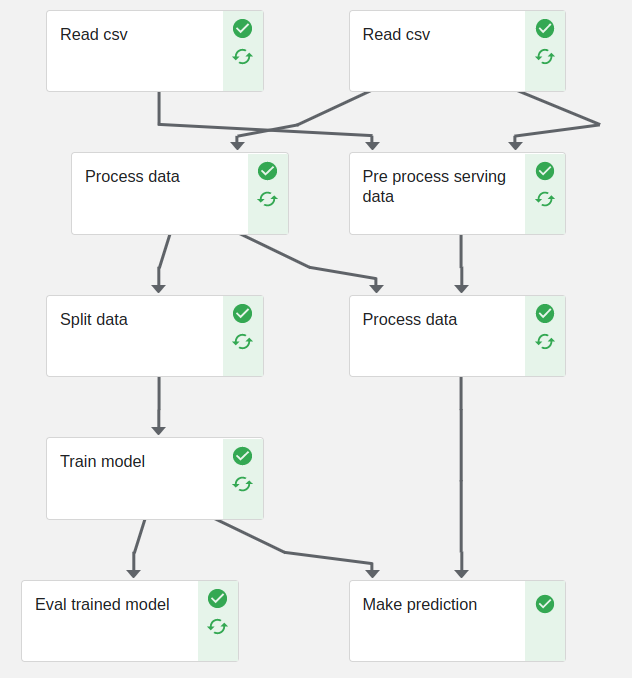

## Table of contents:

* [1. Installation and preparation of the environment](#1)
* [2. Run the Developed Pipeline on Kubeflow](#2)
* [3. Answer to the last two questions (e and f)](#3)

## 1. Installation and preparation of the environment <a class="anchor" id="1"></a>

### 1.1  If you have an existing Kubernetes cluster, run in cmd: 
```shell
export PIPELINE_VERSION=1.8.5
kubectl apply -k "github.com/kubeflow/pipelines/manifests/kustomize/cluster-scoped-resources?ref=$PIPELINE_VERSION"
kubectl wait --for condition=established --timeout=60s crd/applications.app.k8s.io
kubectl apply -k "github.com/kubeflow/pipelines/manifests/kustomize/env/dev?ref=$PIPELINE_VERSION"
```

**Get Kubeflow Pipelines public URL for later use:**
```shell
kubectl describe configmap inverse-proxy-config -n kubeflow | grep googleusercontent.com
```

### 1.2 If you don't have a Kubernetes cluster yet, you can deploy the kubeflow pipeline standalone in a local kubernetes cluster environment

- First you need to install [kind](https://kind.sigs.k8s.io/). It's a tool for running local Kubernetes clusters using Docker container nodes. You can find the official installtion guide [here](https://kind.sigs.k8s.io/docs/user/quick-start/#installation) 
- If you are a Linux user, you can follow these quick instructions :
```shell
curl -Lo ./kind https://kind.sigs.k8s.io/dl/v0.17.0/kind-linux-amd64
chmod +x ./kind
sudo mv ./kind /usr/local/bin/kind
```

- Create a kind cluster : 
```shell
kind create cluster
```

- Deploy Kubeflow Pipelines : 
```shell
export PIPELINE_VERSION=1.8.5
kubectl apply -k "github.com/kubeflow/pipelines/manifests/kustomize/cluster-scoped-resources?ref=$PIPELINE_VERSION"
kubectl wait --for condition=established --timeout=60s crd/applications.app.k8s.io
kubectl apply -k "github.com/kubeflow/pipelines/manifests/kustomize/env/platform-agnostic-pns?ref=$PIPELINE_VERSION"
```

- Verify that the Kubeflow Pipelines UI is accessible by port-forwarding :
```shell
ubectl port-forward -n kubeflow svc/ml-pipeline-ui 8080:80
```

The Kubeflow Pipelines UI at **http://localhost:8080/**

- For uninstalling Kubeflow Pipelines, please follow these [instructions](https://www.kubeflow.org/docs/components/pipelines/v1/installation/localcluster-deployment/#uninstalling-kubeflow-pipelines)

## 2. Run the Developed Pipeline on Kubeflow <a class="anchor" id="1"></a>

- Since FBprophet is not tuned enough to serve it in production, we decided to deploy the XGboost model which gives better results.
- The following instructions are for running the developed pipeline in the decathlon_pipeline.py script. You can also run the pipeline using .yaml files, but that won't be covered here.

To run the script from the command line, you need to specify some main arguments, such as data train path, data test path, and data evaluation start date. For simplicity, the git repository is set as the default data path. You can choose your preferred data storage location.

See help for using other arguments : 

In [102]:
!python3 ../deployment_pipeline/decathlon_pipeline.py --help

usage: DecathlonKubeflowPipeline [-h] [--host HOST]
                                 [--train_path DATA_TRAIN_URL]
                                 [--serve_path DATA_SERVE_URL]
                                 [--cat_columns CATEGORICAL_COLUMNS]
                                 [--eval_date EVAL_START_DATE]
                                 [--n_estimators N_ESTIMATORS]
                                 [--n_jobs N_JOBS] [--max_depth MAX_DEPTH]
                                 [--random_state RANDOM_STATE]

Create and deploy an ML pipeline to train and serve decathlon turnover
forecasts

optional arguments:
  -h, --help            show this help message and exit
  --host HOST           Kubeflow pipelines UI url
  --train_path DATA_TRAIN_URL
                        train data path or url
  --serve_path DATA_SERVE_URL
                        serving(test) data path or url
  --cat_columns CATEGORICAL_COLUMNS
                        categorical columns to one hot encode
  --eval_date EVAL_S

Let's run the script with custom arguments : 
- NB : For fast execution, set n_estimators to 1 and max_depth to 5

In [128]:
%%bash
python3 ../deployment_pipeline/decathlon_pipeline.py --host 'http://localhost:8080' \
   --train_path 'https://github.com/seifou23i/decathlon_challenge/raw/master/data/inputs/train/train.csv'\
   --serve_path 'https://github.com/seifou23i/decathlon_challenge/raw/master/data/inputs/test/test.csv'\
   --eval_date '2017-09-14' \
   --n_estimators 1 \
   --max_depth 5 \
   --n_jobs -1 \
   --random_state 42                                 

/home/seif-eddine/.cache/pypoetry/virtualenvs/decathlon-challenge-q9wdcmzZ-py3.9/lib/python3.9/site-packages/kfp/components/_data_passing.py:227: UserWarning: Missing type name was inferred as "Integer" based on the value "200".
  warnings.warn(
/home/seif-eddine/.cache/pypoetry/virtualenvs/decathlon-challenge-q9wdcmzZ-py3.9/lib/python3.9/site-packages/kfp/components/_data_passing.py:227: UserWarning: Missing type name was inferred as "Integer" based on the value "-1".
  warnings.warn(
/home/seif-eddine/.cache/pypoetry/virtualenvs/decathlon-challenge-q9wdcmzZ-py3.9/lib/python3.9/site-packages/kfp/components/_data_passing.py:227: UserWarning: Missing type name was inferred as "Integer" based on the value "20".
  warnings.warn(
/home/seif-eddine/.cache/pypoetry/virtualenvs/decathlon-challenge-q9wdcmzZ-py3.9/lib/python3.9/site-packages/kfp/components/_data_passing.py:227: UserWarning: Missing type name was inferred as "Integer" based on the value "42".
  warnings.warn(


Go to the kubeflow pipelines UI at http://localhost:8080/#/runs to see your pipeline :

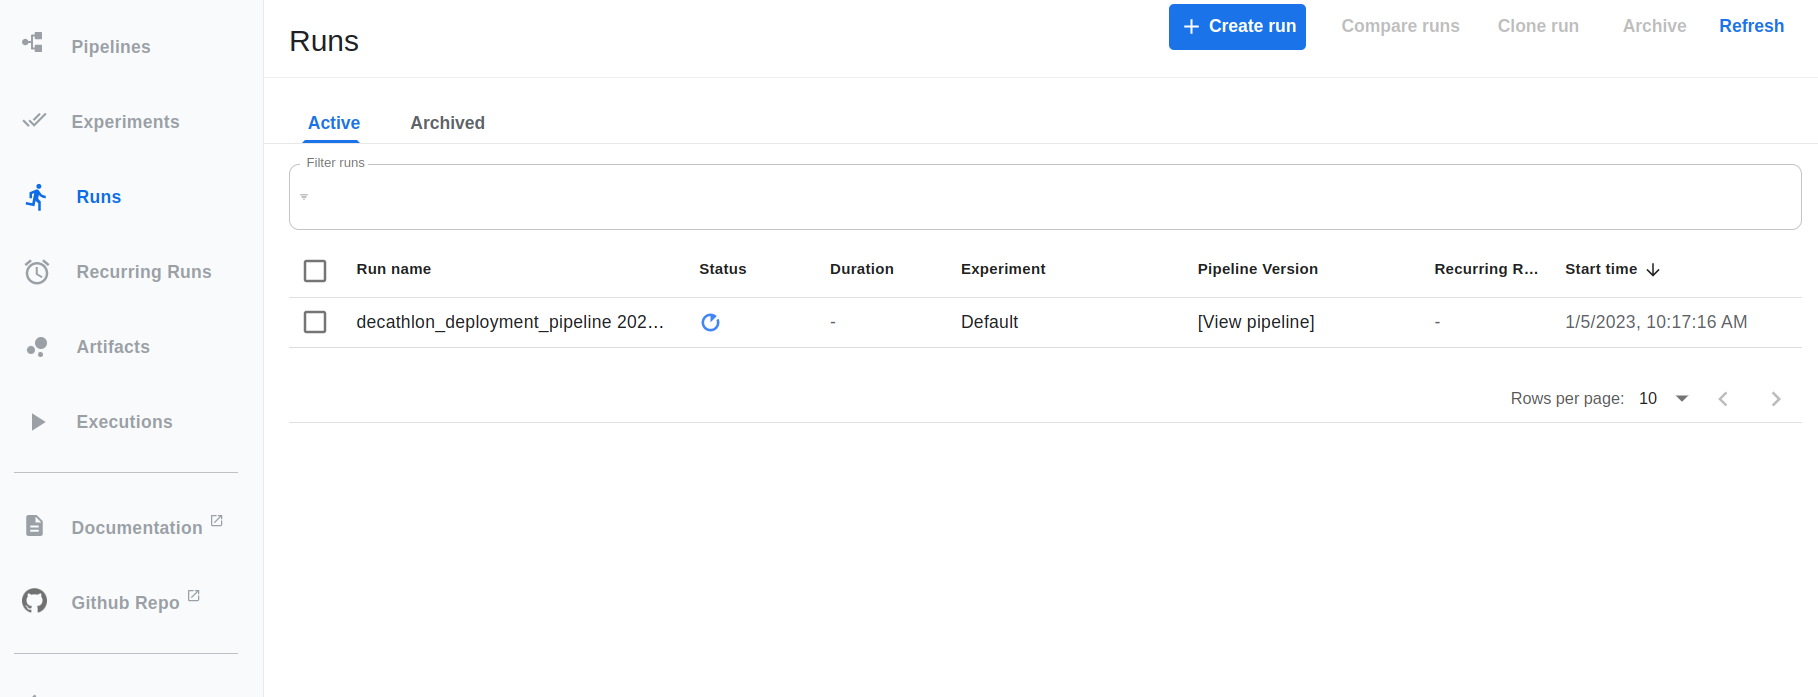

Click on the ddeployment_pipeline_2023-XX-XX XX-XX-XX  to see your execution progress : 

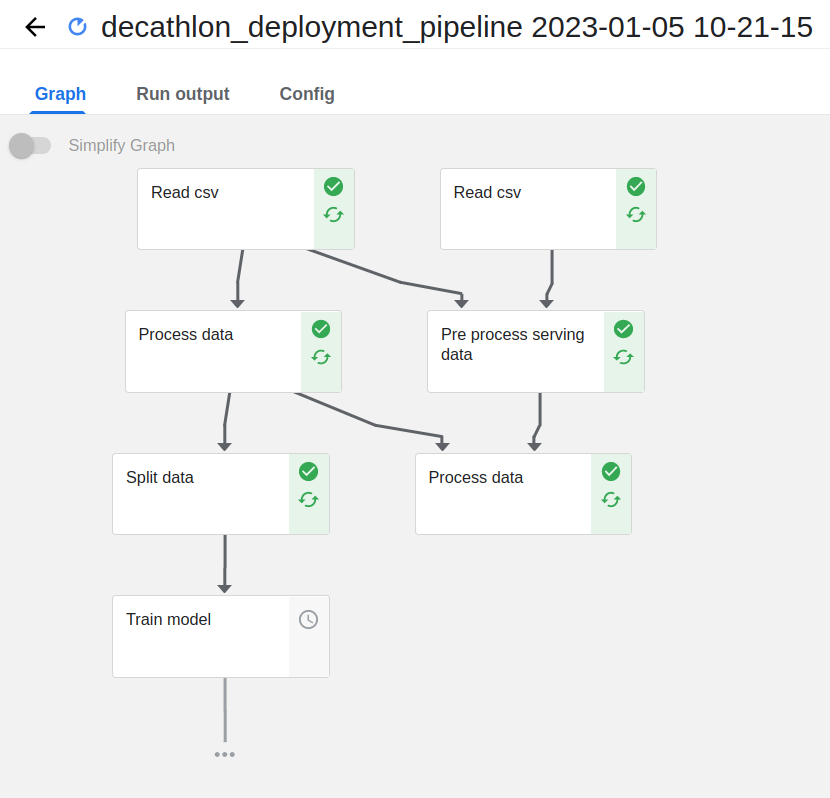

You can explore components input/output artifacts by clicking on the component, for example the prediction component :

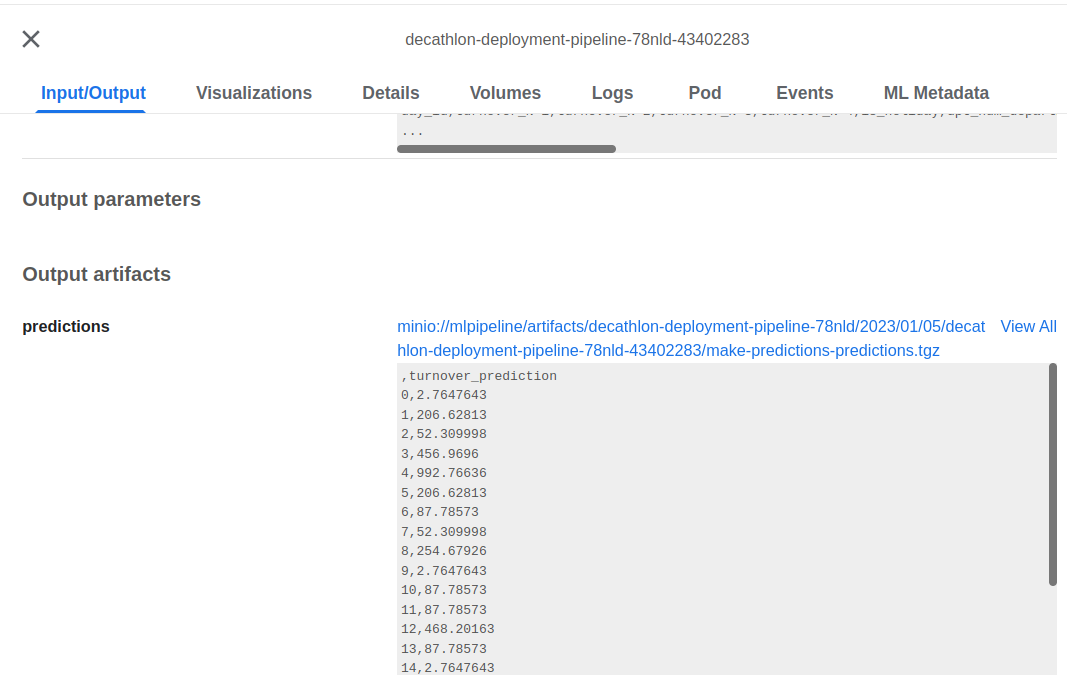

**- Note that in production, this output is passed to other downstream components for service or model monitoring**

**- Don't forget to uninstall Kubeflow pipelines to free up space [instructions](https://www.kubeflow.org/docs/components/pipelines/v1/installation/localcluster-deployment/#uninstalling-kubeflow-pipelines)**

## 3. Answer to the last two questions (e and f)

#### e. Describe some common issues involved in the deployment of machine learning models
- the main issue involved in the deployment of ML models in production is reproducibility. this occurs when development results differ significantly from production results due to the change in environment: libraries versions, compute units type(cpu, gpu, tpu), distribution strategies, etc.
- The performance of the deployed model degrades over time due to changing data distribution. This phenomenon is called data drift. The model should be trained periodically to avoid model skew, even if the model is well generalized. We will detail this issue in the following question

#### f. Propose a solution which monitors the the model performance in productin

Three main solutions can be applied independently or at the same time :
   - Data Drift Monitoring: Periodically compare the distribution of train data and a subset of new data. If data drift is observed, we send a notification. This solution already exists with the TFX pipeline toolkit
   - Model Monitoring: Periodically evaluate model performance on new data. If the performance exceeds a certain threshold, retrain the model on new and past data. 

The second solution can use the model evaluation component(in the pipeline) to evaluate the performance of the model and train the model if necessary.